In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
os.chdir("..")
from model import run_experiments
from model.config.params import build_params
import numpy as np
from cadCAD.engine import ExecutionMode

df, simulation_kpis = run_experiments(["BaseEvent", "BaseDynamic", "Base"], context = ExecutionMode().local_mode)

/Users/seanmcowen/opt/anaconda3/envs/BlockScience/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.5.0
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (3, 1095, 222, 3, 27)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (365, 74, 1, 27)
     Simulation 1: (Timesteps, Params, Runs, Sub-States) = (365, 74, 1, 27)
     Simulation 2: (Timesteps, Params, Runs, Sub-States) = (365, 74, 1, 27)


Initializing configurations: 100%|███████████████| 3/3 [00:00<00:00, 117.26it/s]

Execution Method: parallelize_simulations
Execution Mode: parallelized


2023-12-20 17:25:52.015141
2023-12-20 17:25:52.021289
2023-12-20 17:25:52.027954


Flattening results: 100%|████████████████████████| 3/3 [00:00<00:00, 123.91it/s]


Total execution time: 34.02s


In [2]:
df

,simulation,subset,run,timestep,Geozones,Applications,DAO,Gateways,Services,Servicers,...,mint_rate_cummulative,net_mint_rate_cummulative,kpi_c,n_servicers,n_applications,n_gateways,n_services,n_understaked_servicers,n_understaked_gateways,n_understaked_applications
0,0,0,1,0,"[Zone 1, Zone 2, Zone 3, Zone 4, Zone 5]",[<model.classes.application.Application object...,<model.classes.dao.DAO object at 0x7fec6ef9d370>,[<model.classes.gateway.Gateway object at 0x7f...,[<model.classes.service.Service object at 0x7f...,[<model.classes.servicer.Servicer object at 0x...,...,0.000000,0.000000,NaN,10,3,1,8,0,0,0
1,0,0,1,1,"[Zone 1, Zone 2, Zone 3, Zone 4, Zone 5]",[<model.classes.application.Application object...,<model.classes.dao.DAO object at 0x7fec3ca72280>,[<model.classes.gateway.Gateway object at 0x7f...,[<model.classes.service.Service object at 0x7f...,[<model.classes.servicer.Servicer object at 0x...,...,0.000015,0.000013,0.095193,11,4,2,9,0,2,1
2,0,0,1,2,"[Zone 1, Zone 2, Zone 3, Zone 4, Zone 5]",[<model.classes.application.Application object...,<model.classes.dao.DAO object at 0x7fec3d9e6250>,[<model.classes.gateway.Gateway object at 0x7f...,[<model.classes.service.Service object at 0x7f...,[<model.classes.servicer.Servicer object at 0x...,...,0.000035,0.000030,0.093477,11,4,1,9,0,0,0
3,0,0,1,3,"[Zone 1, Zone 2, Zone 3, Zone 4, Zone 5]",[<model.classes.application.Application object...,<model.classes.dao.DAO object at 0x7fec3f59c640>,[<model.classes.gateway.Gateway object at 0x7f...,[<model.classes.service.Service object at 0x7f...,[<model.classes.servicer.Servicer object at 0x...,...,0.000051,0.000043,0.164665,12,4,2,10,0,1,0
4,0,0,1,4,"[Zone 1, Zone 2, Zone 3, Zone 4, Zone 5]",[<model.classes.application.Application object...,<model.classes.dao.DAO object at 0x7fec1989cd00>,[<model.classes.gateway.Gateway object at 0x7f...,[<model.classes.service.Service object at 0x7f...,[<model.classes.servicer.Servicer object at 0x...,...,0.000067,0.000057,0.202086,11,4,2,10,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1093,2,0,1,361,"[Zone 1, Zone 2, Zone 3, Zone 4, Zone 5]",[<model.classes.application.Application object...,<model.classes.dao.DAO object at 0x7fec88ab3c10>,[<model.classes.gateway.Gateway object at 0x7f...,[<model.classes.service.Service object at 0x7f...,[<model.classes.servicer.Servicer object at 0x...,...,0.019039,0.016550,0.117303,17,14,2,10,0,2,0
1094,2,0,1,362,"[Zone 1, Zone 2, Zone 3, Zone 4, Zone 5]",[<model.classes.application.Application object...,<model.classes.dao.DAO object at 0x7fec88b6e4f0>,[],[<model.classes.service.Service object at 0x7f...,[<model.classes.servicer.Servicer object at 0x...,...,0.019087,0.016589,0.113797,17,14,0,10,0,0,0
1095,2,0,1,363,"[Zone 1, Zone 2, Zone 3, Zone 4, Zone 5]",[<model.classes.application.Application object...,<model.classes.dao.DAO object at 0x7fec7da3bbe0>,[<model.classes.gateway.Gateway object at 0x7f...,[<model.classes.service.Service object at 0x7f...,[<model.classes.servicer.Servicer object at 0x...,...,0.019136,0.016629,0.127575,17,14,1,10,0,1,0
1096,2,0,1,364,"[Zone 1, Zone 2, Zone 3, Zone 4, Zone 5]",[<model.classes.application.Application object...,<model.classes.dao.DAO object at 0x7fec7daf5520>,[<model.classes.gateway.Gateway object at 0x7f...,[<model.classes.service.Service object at 0x7f...,[<model.classes.servicer.Servicer object at 0x...,...,0.019184,0.016668,0.101029,16,14,1,10,0,0,0


## Basic Line Graphs

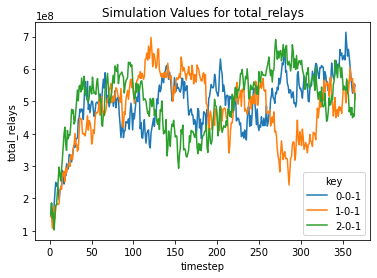

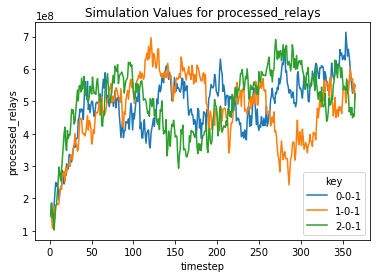

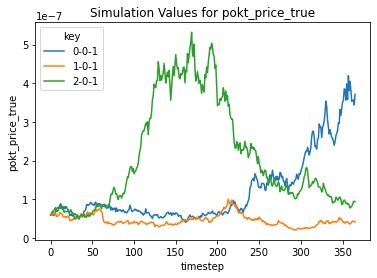

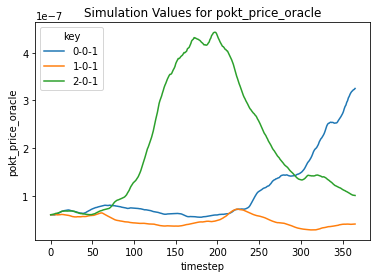

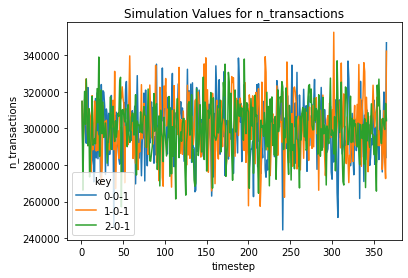

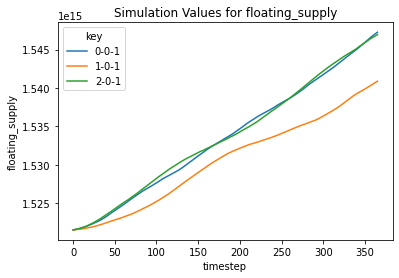

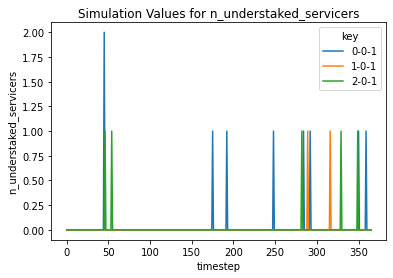

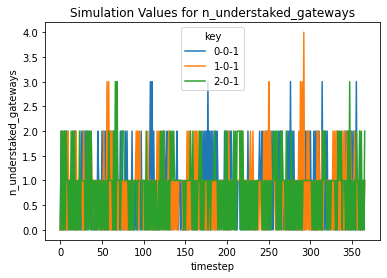

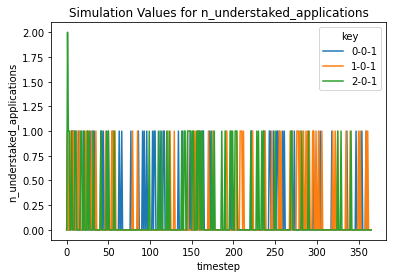

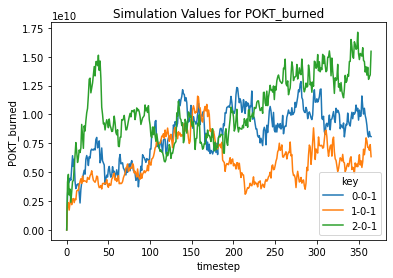

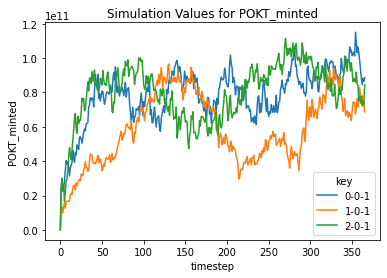

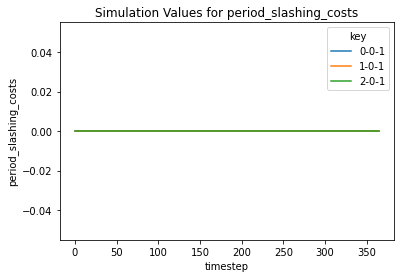

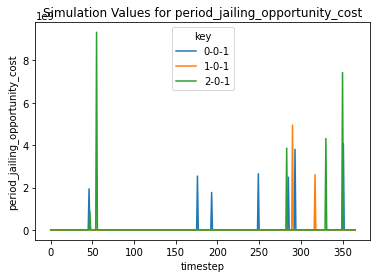

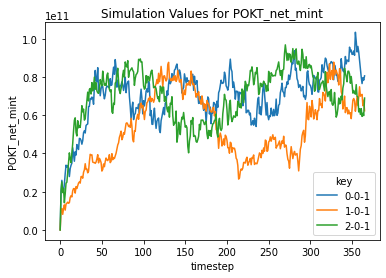

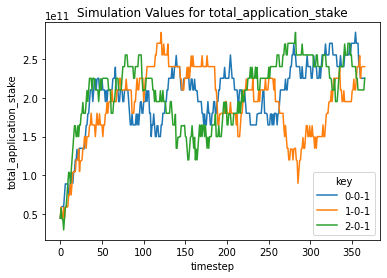

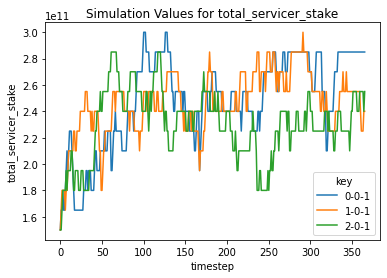

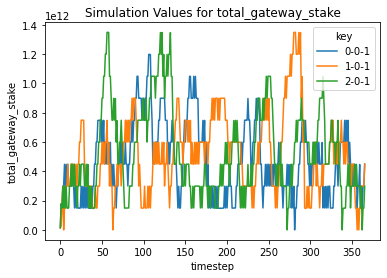

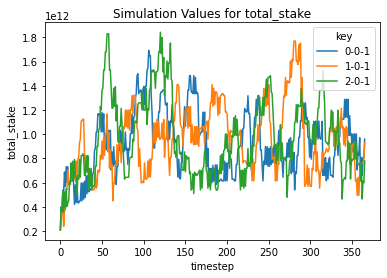

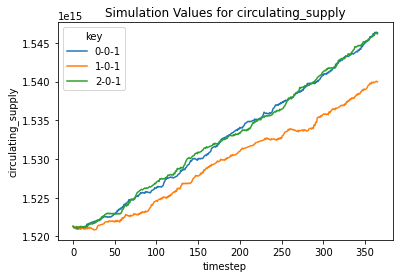

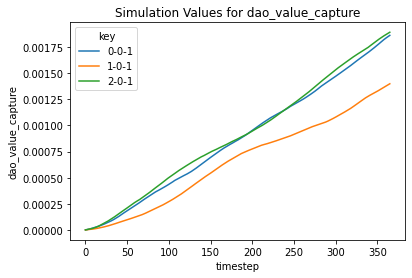

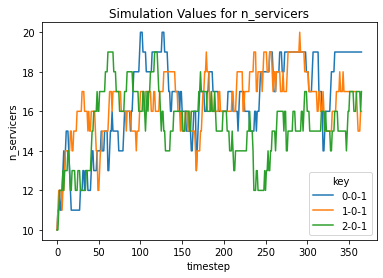

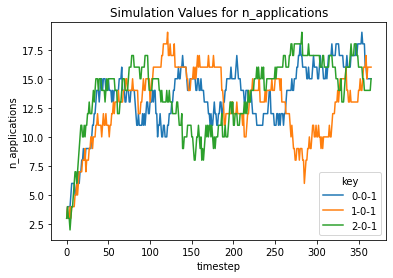

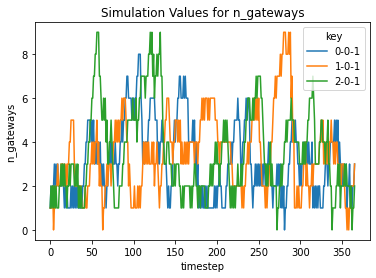

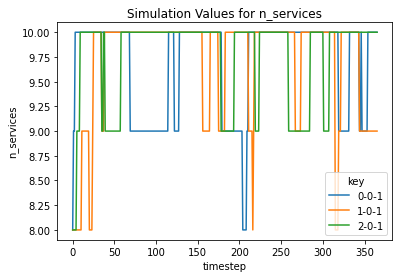

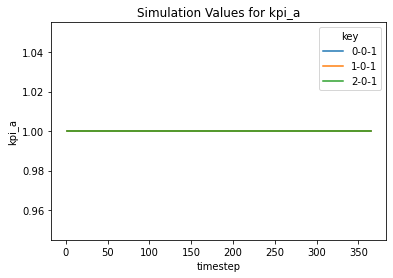

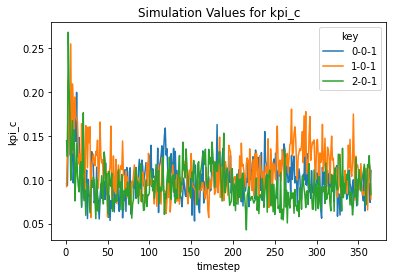

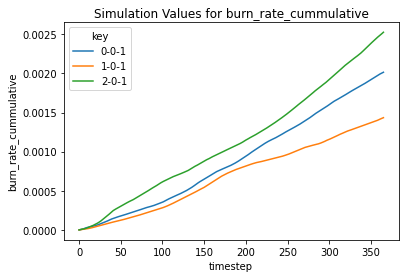

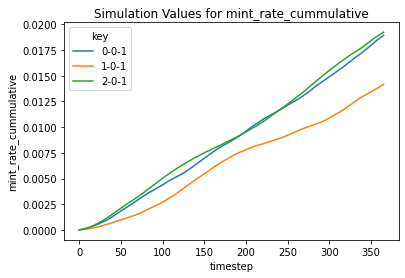

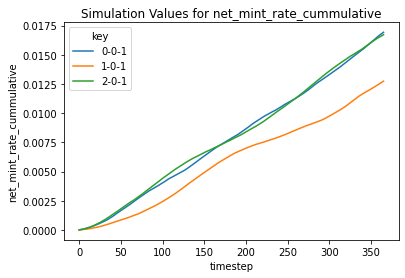

In [3]:
for col in ['total_relays', 'processed_relays', 'pokt_price_true', 'pokt_price_oracle',
           'n_transactions', 'floating_supply', 'n_understaked_servicers', 'n_understaked_gateways',
            'n_understaked_applications', 'POKT_burned', 'POKT_minted','period_slashing_costs',
            'period_jailing_opportunity_cost','POKT_net_mint', 'total_application_stake',
            'total_servicer_stake', 'total_gateway_stake', 'total_stake', 'circulating_supply',
            'dao_value_capture', 'n_servicers', 'n_applications', 'n_gateways',
           'n_services', 'kpi_a', 'kpi_c', 'burn_rate_cummulative',
       'mint_rate_cummulative', 'net_mint_rate_cummulative']:
    # Grab the pivot table
    table = df.pivot(index="timestep", columns="key", values=col)
    
    # Plot
    table.plot(kind = 'line')
    plt.xlabel("timestep")
    plt.ylabel(col)
    plt.title("Simulation Values for {}".format(col))
    
    plt.show()